# Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Shareddrives/DuongLuongHoa-BKHN/DRL-RSMA-Radar
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/DuongLuongHoa-BKHN/DRL-RSMA-Radar
'Copy of DRL-RSMA-Radar.ipynb'	 DRL-RSMA-Radar.ipynb


In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(600, 400))
    dis.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0

# Library definition

In [ ]:
# Fundamental
import numpy as np

import math
import copy
import random
from typing import Dict, List, Tuple

import scipy
from scipy import special
from scipy.special import lambertw

import matplotlib.pyplot as plt

# Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

dtype = np.float32


from IPython.display import clear_output

In [ ]:
# GPU 
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print("GPU enabled")

seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

GPU enabled


# Environment 

## Definition of Channel








## Code

### CNUR settings
Here is a CNUR settings

| Notations            | Value        ||| Notations            | Value        | 
|---                   |---           ||| ---                  | ---          | 
|Number of CU (Q)      | 10 - 20      ||| Antenna Gain T BS    |  17dBi~50    | 
|Wave length (lambda)  | 0.1m         ||| Antenna Gain R BS    |   0dBi~1     | 
|BS to CU              | 200-300m     ||| Antanna Gain Radar   |  30dBi~1000  | 
|Radar to CU           | 1000-2000m   ||| G'^R_t               | -27dBi~0.002 | 
|Radar to UAV          | 5000-10000m  ||| G'^R_r               | -27dBi~0.002 | 
|P_BS                  | 30 dBm / 1W  ||| sigma_RCS            | 1m^2         | 
|P_radar               | 1000W        ||| sigma^2_q, sigma^2   | -150dBm/Hz   | |B                     | 10^6         ||| C^TH                 | 10^5 - 4*10^5| 

In [ ]:
class Env_CNUR():
    ### Initialization ###
    def __init__(self, MAX_EP_STEPS, N_user_max,   
                 BS_R_min, BS_R_max, radar_R,           # Radius of BS and Radar distance to BS
                 h_max, h_min,                          # Height of the UAV
                 uav_R_max, uav_R_min,                  # Radius of the UAV
                #  Radar_R_max,                         # Radius of the Radar
                 C_TH,                                  # Datarate threshold
                 P_BS_max, P_radar_max,                 # Power
                 Bandwidth, noise):                     # Data Rate, Bandwidth
        # Visualization
        self.visualization = "2D"          # 3D or else
        # Data logging
        self.verbose_distance = False
        self.verbose_channelGain = False
        self.verbose_SINR = False
        self.verbose_DataRate = False

        # Network settings
        self.BS_R_max = BS_R_max           # Base Station maximum radius
        self.BS_R_min = BS_R_min           # Base Station minimum radius
        self.N_User = N_user_max           # Number of User / m
        self.P_BS_max  = P_BS_max          # Base Station 's max power / m
        self.noise  = noise                # Noise density: -174 dBm/Hz
        self.B      = Bandwidth            # Bandwidth
        self.C_TH   = C_TH                 # Lower threshold for data rate - CU

        self.n_0 = noise**2 * self.B       # Noise power     
        self.lambda_c = 0.1                #   
        # Power setting
        self.P_CU   = 1                    # 1W
        self.P_R    = 1000                 # P_radar_max = 1000
        self.P_BS_0 = np.random.uniform(self.P_BS_max/2, self.P_BS_max)
        self.P_BS_U = (self.P_BS_max / self.N_User)* np.ones((self.N_User, 1))        

        # Antenna Gain
        self.G_R_t = 1000                               # Transmitting Radar Gain
        self.G_R_r = 1000                               # Transmitting Radar Gain
        self.G_R_t_s = 0.002
        self.G_R_r_s = 0.002
        self.G_C_t = 50                                 # Transmitting BS Gain
        self.G_CU_list = np.ones((self.N_User,1))       # Receiving antenna gain of all CUs
        self.sigma_RCS = 1                              # Radar coss section of target - Radar
        self.sigma2 = -10**(-18)                        # W/Hz

        # Base Station initialization
        self.P_max = P_BS_max              # Max power        
        self.BS_x = 0                      # BS location initialization 
        self.BS_y = 0                      # BS location initialization 
        self.BS_location = np.expand_dims(self._location_BS_Generator(), axis=0)
        self.Common_User_Allocation = np.random.rand(self.N_User,1)

        # Radar initialization
        self.Radar_R = radar_R             # Radius
        self.Gamma_R = 10                  # dB ??? 
        self.Radar_location = np.expand_dims(self._location_Radar_Generator(), axis=0)

        # UAV initialization
        self.uav_h_max = h_max             # Height max
        self.uav_h_min = h_min             # Height min
        self.uav_R_max = uav_R_max         # R UAV max 
        self.uav_R_min = uav_R_min         # R UAV min 
        self.UAV_location   = np.expand_dims(self._location_UAV_Generator()  , axis=0)
        self.UAV_trajectory = np.expand_dims(self._trajectory_UAV_Generator(), axis=0)

        # User location initialization
        self.CU_location = self._location_CU_Generator()
        
        # Distance calculation

        self.distance_Radar_UAV    = self._calculateDistance(self.UAV_location, self.Radar_location)
        self.distance_BS_Radar     = self._calculateDistance(self.UAV_location, self.BS_location)
        self.distanceList_BS_CU    = self._calculateDistance(self.BS_location , self.CU_location)
        self.distanceList_Radar_CU = self._calculateDistance(self.CU_location , self.Radar_location)
        if self.verbose_distance == True:
            print("Distance")
            print(f"radar-uav: {self.distance_Radar_UAV}")
            print(f"radar-bs: {self.distance_BS_Radar}")
            print(f"bs-cu: {self.distanceList_BS_CU}")
            print(f"radar-cu: {self.distanceList_Radar_CU}")
         
        # Channel Gain
        self.H_R  = self._channelGain_Radar_UAV()        # Channel round-trip between Radar and UAV
        self.H_CR = self._channelGain_BS_Radar()         # Channel from BS to Radar
        self.H_C  = self._channelGain_BS_CU()            # Channel from BS to CU    (Interference)
        self.H_RC = self._channelGain_Radar_CU()         # Channel from Radar to CU (Interference)
        if self.verbose_channelGain == True:
            print("Channel Gain")
            print(f"radar-uav: {self.H_R}")
            print(f"radar-bs: {self.H_CR}")
            print(f"bs-cu: {self.H_C}")
            print(f"radar-cu: {self.H_RC}")            

        # SINR calculation
        self.SINR_Radar = self._SINR_Radar(power_radar = self.P_R, 
                                           power_bs_comm = self.P_BS_0, power_bs_priv = self.P_BS_U,
                                           H_radar_uav = self.H_R, H_BS_radar = self.H_CR)
        if self.verbose_SINR == True:
            print(f"SINR: {self.SINR_Radar}")
        self.commonDataRate, self.privateDataRate = self._calculateDataRate(self.H_C, self.H_RC)
        if 0 == 1:
            print(f"common: {self.commonDataRate}")
            print(f"private: {self.privateDataRate}")

        # Environment settings
        "state_size can be represented by number of user initialized each episode"
        self.rewardMatrix = np.array([])

        self.observation_space = self._wrapState().squeeze()
        self.action_space      = self._wrapAction().squeeze()
        self.reward_space      = np.array(())

    ### Functions ###
    # Channel gain generation
    def _channelGain_BS_CU(self):
        numerator   = self.G_C_t * self.G_CU_list * (self.lambda_c**2)
        denominator = ((4*np.pi)**3) * (self.distanceList_BS_CU**4)
        channelGain = numerator/denominator 
        return channelGain

    def _channelGain_Radar_CU(self):
        numerator   = self.G_R_t * self.G_CU_list * (self.lambda_c**2)
        denominator = ((4*np.pi)**3) * (self.distanceList_Radar_CU**4)
        channelGain = numerator/denominator 
        return channelGain

    def _channelGain_BS_Radar(self):
        numerator   = self.G_C_t * self.G_R_r * (self.lambda_c**2)
        denominator = ((4*np.pi)**3) * (self.distance_BS_Radar**4)
        channelGain = numerator/denominator 
        return channelGain

    def _channelGain_Radar_UAV(self):            # h^R
        numerator   = self.G_R_t * self.G_R_r * self.sigma_RCS * (self.lambda_c**2)
        denominator = ((4*np.pi)**3) * (self.distance_Radar_UAV**4)
        channelGain = numerator/denominator 
        return channelGain

    # Radar initialization
    def _location_BS_Generator(self):
        # r = self.BS_R_max * np.sqrt(np.random.rand())
        # theta = np.random.uniform(-np.pi, np.pi)
        # Radar_x = self.BS_x + r*np.cos(theta)
        # Radar_y = self.BS_y + r*np.sin(theta)
        BS_location = [self.BS_x, self.BS_y, 0]
        return np.array(BS_location)

    # Radar initialization
    def _location_Radar_Generator(self):
        r = self.Radar_R * np.sqrt(np.random.rand())
        theta = np.random.uniform(-np.pi, np.pi)
        Radar_x = self.BS_x + r*np.cos(theta)
        Radar_y = self.BS_y + r*np.sin(theta)
        Radar_location = [Radar_x, Radar_y, 0]
        return np.array(Radar_location)

    # UAV initialization
    def _location_UAV_Generator(self):
        # h_min < h < h_max
        # -180 < theta < 180 (Oxy hyper-space)
        # 0 < R < R_Max
        r = self.uav_R_max * np.sqrt(np.random.rand())
        theta = np.random.uniform(-np.pi, np.pi)
        UAV_x = self.BS_x + r*np.cos(theta)
        UAV_y = self.BS_y + r*np.sin(theta)
        UAV_h = np.random.uniform(self.uav_h_min, self.uav_h_max)
        UAV_location = [UAV_x, UAV_y, UAV_h]
        return np.array(UAV_location)

    def _trajectory_UAV_Generator(self):
        theta  = 0
        theta  = theta + np.pi/360
        r      = np.sin(theta)
        UAV_vx = r*np.cos(2*theta)
        UAV_vy = r*np.sin(2*theta)
        UAV_vh = 0
        UAV_trajectory = [UAV_vx, UAV_vy, UAV_vh]
        return np.array(UAV_trajectory)

    # User distance initialization
    def _location_CU_Generator(self):
        # Generate random CU locations
        # N_User: number of users
        # BS_R_min, BS_R_max: circle radius
        # [BS_x, BS_y]: center of the circle
        userList = []
        for i in range(self.N_User):
            r = self.BS_R_max * np.sqrt(np.random.rand())
            # theta =  i/self.N_User*2*np.pi + np.random.uniform(-np.pi/10, np.pi/10)
            theta = np.random.uniform(-np.pi, np.pi)
            xUser_temp = self.BS_x + r*np.cos(theta)
            yUser_temp = self.BS_y + r*np.sin(theta)
            userList.append([xUser_temp, yUser_temp, 0])
            
        comm_user = np.array(userList)
        if self.visualization == "2D":
            #Plot scatter figure
            fig, ax = plt.subplots()
            circle1 = plt.Circle((self.BS_x, self.BS_y), 1, color='r', fill=True)
            circle2 = plt.Circle((self.BS_x, self.BS_y), self.BS_R_min, color='g', fill=False)
            circle3 = plt.Circle((self.BS_x, self.BS_y), self.BS_R_max, color='b', fill=False)
            ax.add_patch(circle1)
            ax.add_patch(circle2)
            ax.add_patch(circle3)
            # print(comm_user.transpose()[0:2].transpose())
            gu = comm_user.transpose()[0:2].transpose()
            plt.scatter(gu[:,0], gu[:,1])
            plt.show()
        # elif self.visualization == "3D":
        #     fig = plt.figure()
        #     ax = fig.add_subplot(projection='3d')
        #     circle1 = plt.Circle((self.BS_x, self.BS_y, 0), 1, color='r', fill=True)
        #     circle2 = plt.Circle((self.BS_x, self.BS_y, 0), self.BS_R_min, color='g', fill=False)
        #     circle3 = plt.Circle((self.BS_x, self.BS_y, 0), self.BS_R_max, color='b', fill=False)
        #     n = 100

        #     # For each set of style and range settings, plot n random points in the box
        #     # defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
        #     for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
        #         xs = randrange(n, 23, 32)
        #         ys = randrange(n, 0, 100)
        #         zs = randrange(n, zlow, zhigh)
        #         ax.scatter(xs, ys, zs, marker=m)

        #     ax.set_xlabel('X')
        #     ax.set_ylabel('Y')
        #     ax.set_zlabel('Height')

        #     plt.show()            
        return comm_user

    # SINR Calculator
    ### power_bs_comm = 1 value
    ### power_bs_priv = N_User value
    ### power_radar   = 1 value
    ### H_radar_uav   = 1
    ### H_userradar   = N_User value
    def _SINR_Radar(self, power_radar, power_bs_comm, power_bs_priv,
                    H_radar_uav, H_BS_radar):
        numerator = (H_radar_uav**2)*power_radar
        denominator = (H_BS_radar**2) * (power_bs_comm + np.sum(power_bs_priv)) + (self.B*(self.sigma2))
        SINR = numerator/denominator
        return SINR

    def _calculateDistance(self, A, B):
        return np.array([np.sqrt(np.sum((A - B)**2,axis=1))]).transpose()
    
    def _selfExcluded_MatrixSum(self, V):
        # Private user exclude sum of user at this point
        # Clone P_BS_U vector into P_BS_U matrix 
        clonedM = np.ones((len(V),1))*V
        # Remove diagonal
        diagonalExcludedM = clonedM -np.diag(np.diag(clonedM))
        # Sum over self-excluded matrix
        rowWise_SumM = np.matrix(diagonalExcludedM).sum(axis=1)
        return rowWise_SumM

    def _calculateDataRate(self, channelGain_BS_CU, channelGain_Radar_CU):
        # Generate partial components
        interferenceRadarUser   = ((channelGain_Radar_CU)**2)*self.P_R

        sumCommonUserPower      = np.sum(self.P_BS_U)
        sumPrivateUserPower     = self._selfExcluded_MatrixSum(self.P_BS_U)

        interferenceCommonUser  = ((channelGain_BS_CU)**2)*sumCommonUserPower  

        interferencePrivateUser = np.multiply(((channelGain_BS_CU)**2),np.array([sumPrivateUserPower]).transpose())
        interferenceBandwidth   = self.B*self.sigma2
        
        commonNumerator       = ((channelGain_BS_CU)**2)*self.P_BS_0
        commonDenominator     = interferenceCommonUser + interferenceCommonUser + interferenceBandwidth
        
        privateNumerator      = ((channelGain_BS_CU)**2)*self.P_BS_U
        privateDenominator    = interferencePrivateUser + interferenceCommonUser + interferenceBandwidth
        
        commonDataRate  = self.B * np.log2(1+(commonNumerator/commonDenominator))
        privateDataRate = self.B * np.log2(1+(privateNumerator/privateDenominator))
        if self.verbose_DataRate == True:
            print(f"sumPrivateUserPower: {sumPrivateUserPower}")
            print(f"interferenceCommonUser: {interferenceCommonUser}")
            print(f"interferencePrivateUser: {interferencePrivateUser}")
            print(f"interferenceBandwidth: {interferenceBandwidth}")
            print(f"commonNumerator: {commonNumerator}")
            print(f"commonDenominator: {commonDenominator}")
            print(f"privateNumerator: {privateNumerator}")
            print(f"privateDenominator: {privateDenominator}")
        return commonDataRate, privateDataRate

    def _wrapState(self):
        # Channel Gain
        self.H_R  = self._channelGain_Radar_UAV()        # Channel round-trip between Radar and UAV
        self.H_CR = self._channelGain_BS_Radar()         # Channel from BS to Radar
        self.H_C  = self._channelGain_BS_CU()            # Channel from BS to CU    (Interference)  
        self.H_RC = self._channelGain_Radar_CU()         # Channel from Radar to CU (Interference)  
        if self.verbose_channelGain == True:
            print("Channel Gain")
            print(f"radar-uav: {self.H_R}")
            print(f"radar-bs: {self.H_CR}")
            print(f"bs-cu: {self.H_C}")    
            print(f"radar-cu: {self.H_RC}")

        # SINR calculation
        self.SINR_Radar = self._SINR_Radar(power_radar = self.P_R,                                  
                                           power_bs_comm = self.P_BS_0, power_bs_priv = self.P_BS_U,
                                           H_radar_uav = self.H_R, H_BS_radar = self.H_CR)          
        if self.verbose_SINR == True:
            print(f"SINR: {self.SINR_Radar}")
        self.commonDataRate, self.privateDataRate = self._calculateDataRate(self.H_C, self.H_RC)

        # print(np.shape(self.H_RC))
        # print(np.shape(self.H_C))
        # print(np.shape(self.H_CR))
        # print(np.shape(self.H_R))
        # print(np.shape(self.UAV_location))
        # print(np.shape(self.UAV_trajectory))

        state = np.concatenate((np.array(self.H_RC).reshape(1,self.N_User), np.array(self.H_C).reshape(1,self.N_User),                    
                                np.array(self.H_CR), np.array(self.H_R),                    
                                np.array(self.UAV_location), np.array(self.UAV_trajectory)
                               ), axis = 1)

        return state

    def _wrapAction(self):
        action = np.concatenate((np.array([[self.P_BS_0]]), np.array(self.P_BS_U).reshape(1,self.N_User),                    
                                np.array([[self.P_R]]), np.array(self.Common_User_Allocation).reshape(1,self.N_User)                    
                               ), axis = 1)
        return action

    def _decomposeState(self, state):
        H_RC = state[0 : self.N_user]
        H_C  = state[self.N_User     : 2*self.N_User]
        H_CR = state[2*self.N_User   : 2*self.N_User+1]
        H_R  = state[2*self.N_User+1 : 2*self.N_User+2]
        UAV_location   = state[self.N_User+2 : 2*self.N_User+5]
        UAV_trajectory = state[self.N_User+5 : 2*self.N_User+8]
        return  [
                 np.array(H_RC).reshape(self.N_User,1), np.array(H_C).reshape(self.N_User,1),                    
                 np.array(H_CR), np.array(H_R),                    
                 np.array(UAV_location), np.array(UAV_trajectory)
                ]

    def _decomposeAction(self, action):
        P_BS_0 = action[0:1]
        P_BS_U = action[1:1+self.N_User]
        P_R    = action[1+self.N_User: 2+self.N_User]
        Common_User_Allocation = action[2+self.N_User:2+2*self.N_User]
        return [
                np.array(P_BS_0), np.array(P_BS_U), 
                np.array(P_R), np.array(Common_User_Allocation)
               ]

    ###########################
    # DRL Environment process #
    def step(self, action):
        # Current state decomposition
        # State: [H_RC, H_C, H_CR, H_R, UAV_location, UAV_trajectory]
        # self.H_RC, self.H_C, self.H_CR, self.H_R, self.UAV_location, self.UAV_trajectory = self._decomposeState()
        # Current action decomposition
        # Action: [P_BS_0, P_BS_U, P_R, Common_User_Allocation]
        self.P_BS_0, self.P_BS_U, self.P_R, self.Common_User_Allocation = self._decomposeAction(action)

        # Environment changed
            # UAV moves
        self.UAV_trajectory = np.expand_dims(self._trajectory_UAV_Generator(), axis=0)
        self.UAV_location = self.UAV_location + self.UAV_trajectory
            # Users move
      
        # state wrap [Radar-UAV, BS-Radar, BS-CU, Radar-CU]
        state_next = self._wrapState()
        # Re-calculate dataRate
        self.commonDataRate, self.privateDataRate = self._calculateDataRate(self.H_C, self.H_RC)  
        # Re-generate current Radar-SINR
        self.SINR_Radar = self._SINR_Radar(power_radar = self.P_R,                                  
                                           power_bs_comm = self.P_BS_0, power_bs_priv = self.P_BS_U,
                                           H_radar_uav = self.H_R, H_BS_radar = self.H_CR)          
        # Total dataRate
        cRate = np.sum(self.privateDataRate) + np.min(self.commonDataRate)
        # self.rewardMatrix = np.concatenate((self.rewardMatrix, cRate), axis = 0)

        # Calculate reward (Sum-Rate)
        reward = cRate 

        # If reach number of rounds / achieve the desirable reward -> done
        done = False # not implement yet

        return state_next, reward, done, {}

    def reset(self):
        # Base Station initialization
        self.BS_location = np.expand_dims(self._location_BS_Generator(), axis=0)

        # Radar initialization
        self.Radar_location = np.expand_dims(self._location_Radar_Generator(), axis=0)

        # UAV initialization
        self.UAV_location   = np.expand_dims(self._location_UAV_Generator()  , axis=0)
        self.UAV_trajectory = np.expand_dims(self._trajectory_UAV_Generator(), axis=0)

        # User location initialization
        self.CU_location    = self._location_CU_Generator()
        
        # Distance calculation
        self.distance_Radar_UAV    = self._calculateDistance(self.UAV_location, self.Radar_location)
        self.distance_BS_Radar     = self._calculateDistance(self.UAV_location, self.BS_location)
        self.distanceList_BS_CU    = self._calculateDistance(self.BS_location , self.CU_location)
        self.distanceList_Radar_CU = self._calculateDistance(self.CU_location , self.Radar_location) 
        
        # Generate next state
        state_next = self._wrapState()

        return state_next

    def close(self):
        pass

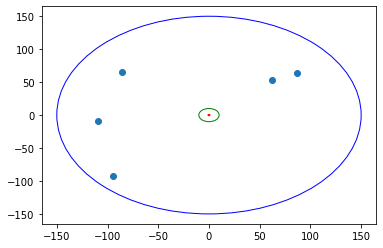

In [ ]:
env = Env_CNUR(MAX_EP_STEPS = 10000, N_user_max = 5,   
               BS_R_min = 10, BS_R_max = 150, radar_R = 1000,     # Radius of BS and Radar distance to BS
               h_max = 500, h_min = 10,                           # Height of the UAV
               uav_R_max = 1000, uav_R_min = 200,                 # Radius of the UAV
               C_TH = 50,                                         # Datarate threshold
               P_BS_max = 100, P_radar_max = 1000, 
               Bandwidth = 100, noise = -174)                     # Power, Data Rate, Bandwidth

# DDPG Agent

## Replay buffer
Typically, people implement replay buffers with one of the following three data structures:

- collections.deque
- list
- numpy.ndarray

**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, **list** is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of Get item is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference), . Whereas list is an array of pointers to objects, even when all of them are of the same type.

Here, we are going to implement a replay buffer using numpy.ndarray.

Reference: 
- [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)
- [rainbow-is-all-you-need](https://render.githubusercontent.com/view/ipynb?commit=032d11277cf2436853478a69ca5a4aba03202598&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f437572742d5061726b2f7261696e626f772d69732d616c6c2d796f752d6e6565642f303332643131323737636632343336383533343738613639636135613461626130333230323539382f30312e64716e2e6970796e62&nwo=Curt-Park%2Frainbow-is-all-you-need&path=01.dqn.ipynb&repository_id=191133946&repository_type=Repository#Replay-buffer)

In [ ]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, action_dim: int, size: int, batch_size: int = 32):
        """Initializate."""
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, action_dim], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros([size], dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        """Store the transition in buffer."""
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

## OU Noise
**Ornstein-Uhlenbeck** process generates temporally correlated exploration, and it effectively copes with physical control problems of inertia.

$$
dx_t = \theta(\mu - x_t) dt + \sigma dW_t
$$

In [ ]:
class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """

    def __init__(
        self, 
        size: int, 
        mu: float = 0.0, 
        theta: float = 0.15, 
        sigma: float = 0.2,
    ):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

## Network

### Old network

In [ ]:
class Actor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Actor, self).__init__()
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, out_dim)        
        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.tanh(self.hidden2(x))
        x = F.relu(self.hidden2(x))
        x = F.tanh(self.hidden2(x))
        x = F.relu(self.hidden2(x))
        action = self.out(x).tanh()
    
        return action
    
    
class Critic(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Critic, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)
        
        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(
        self, state: torch.Tensor, action: torch.Tensor
    ) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.tanh(self.hidden2(x))
        x = F.relu(self.hidden2(x))
        x = F.tanh(self.hidden2(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)
        
        return value

### New network

In [ ]:
# WEIGHTS_FINAL_INIT = 3e-3
# BIAS_FINAL_INIT = 3e-4


# def fan_in_uniform_init(tensor, fan_in=None):
#     """Utility function for initializing actor and critic"""
#     if fan_in is None:
#         fan_in = tensor.size(-1)

#     w = 1. / np.sqrt(fan_in)
#     nn.init.uniform_(tensor, -w, w)


# class Actor(nn.Module):
#     def __init__(self, hidden_size, 
#                  num_inputs, action_space):
#         super(Actor, self).__init__()
#         self.action_space = action_space
#         num_outputs = action_space.shape[0]

#         # Layer 1
#         self.linear1 = nn.Linear(num_inputs, hidden_size[0])
#         self.ln1 = nn.LayerNorm(hidden_size[0])

#         # Layer 2
#         self.linear2 = nn.Linear(hidden_size[0], hidden_size[1])
#         self.ln2 = nn.LayerNorm(hidden_size[1])

#         # Output Layer
#         self.mu = nn.Linear(hidden_size[1], num_outputs)

#         # Weight Init
#         fan_in_uniform_init(self.linear1.weight)
#         fan_in_uniform_init(self.linear1.bias)

#         fan_in_uniform_init(self.linear2.weight)
#         fan_in_uniform_init(self.linear2.bias)

#         nn.init.uniform_(self.mu.weight, -WEIGHTS_FINAL_INIT, WEIGHTS_FINAL_INIT)
#         nn.init.uniform_(self.mu.bias, -BIAS_FINAL_INIT, BIAS_FINAL_INIT)

#     def forward(self, inputs):
#         x = inputs

#         # Layer 1
#         x = self.linear1(x)
#         x = self.ln1(x)
#         x = F.relu(x)

#         # Layer 2
#         x = self.linear2(x)
#         x = self.ln2(x)
#         x = F.relu(x)

#         # Output
#         mu = torch.tanh(self.mu(x))
#         return mu

# class Critic(nn.Module):
#     def __init__(self, hidden_size, 
#                  num_inputs, action_space):
#         super(Critic, self).__init__()
#         self.action_space = action_space
#         num_outputs = action_space.shape[0]

#         # Layer 1
#         self.linear1 = nn.Linear(num_inputs, hidden_size[0])
#         self.ln1 = nn.LayerNorm(hidden_size[0])

#         # Layer 2
#         # In the second layer the actions will be inserted also 
#         self.linear2 = nn.Linear(hidden_size[0] + num_outputs, hidden_size[1])
#         self.ln2 = nn.LayerNorm(hidden_size[1])

#         # Output layer (single value)
#         self.V = nn.Linear(hidden_size[1], 1)

#         # Weight Init
#         fan_in_uniform_init(self.linear1.weight)
#         fan_in_uniform_init(self.linear1.bias)

#         fan_in_uniform_init(self.linear2.weight)
#         fan_in_uniform_init(self.linear2.bias)

#         nn.init.uniform_(self.V.weight, -WEIGHTS_FINAL_INIT, WEIGHTS_FINAL_INIT)
#         nn.init.uniform_(self.V.bias, -BIAS_FINAL_INIT, BIAS_FINAL_INIT)

#     def forward(self, inputs, actions):
#         x = inputs

#         # Layer 1
#         x = self.linear1(x)
#         x = self.ln1(x)
#         x = F.relu(x)

#         # Layer 2
#         x = torch.cat((x, actions), 1)  # Insert the actions
#         x = self.linear2(x)
#         x = self.ln2(x)
#         x = F.relu(x)

#         # Output
#         V = self.V(x)
#         return V

## DDPG Agent
Here is a summary of DDPGAgent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_target_soft_update| soft update from the local model to the target model.|
|\_plot              | plot the training progresses.     

In [ ]:
class DDPGAgent:
    """DDPGAgent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        actor (nn.Module): target actor model to select actions
        actor_target (nn.Module): actor model to predict next actions
        actor_optimizer (Optimizer): optimizer for training actor
        critic (nn.Module): critic model to predict state values
        critic_target (nn.Module): target critic model to predict state values
        critic_optimizer (Optimizer): optimizer for training critic
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        noise (OUNoise): noise generator for exploration
        device (torch.device): cpu / gpu
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """
    def __init__(
        self,
        env,
        memory_size: int,
        batch_size: int,
        ou_noise_theta: float,
        ou_noise_sigma: float,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = 1e4,
    ):
        """Initialize."""
        obs_dim = env.observation_space.shape[0]
        print(env.observation_space.shape)
        action_dim = env.action_space.shape[0]
        print(env.action_space.shape)

        self.env = env
        self.memory = ReplayBuffer(obs_dim, action_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
                
        # noise
        self.noise = OUNoise(
            action_dim,
            theta=ou_noise_theta,
            sigma=ou_noise_sigma,
        )

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        self.critic = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        
        # transition to store in memory
        self.transition = list()
        
        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False
    
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.actor(
                torch.FloatTensor(state).to(self.device)
            ).detach().cpu().numpy()
        else:
            selected_action = self.actor(
                torch.FloatTensor(state).to(self.device)
            ).detach().cpu().numpy()
        
        # add noise for exploration during training
        if not self.is_test:
            noise = self.noise.sample()
            selected_action = np.clip(selected_action + noise, -1.0, 1.0)
        
        self.transition = [state, selected_action]
        
        return selected_action
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            # print(self.transition)
            self.memory.store(*self.transition)
    
        return next_state, reward, done
    
    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines
        
        samples = self.memory.sample_batch()
        state      = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action     = torch.FloatTensor(samples["acts"]).to(device)     
        reward     = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done       = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        if 0 == True: 
            print(f"state size: {np.shape(state)}")

        masks = 1 - done
        next_action = self.actor_target(next_state)
        # print(f"next action: {np.shape(next_action)}")
        next_value = self.critic_target(next_state, next_action)
        curr_return = reward + self.gamma * next_value * masks
        
        # train critic
        values = self.critic(state, action)
        critic_loss = F.mse_loss(values, curr_return)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
                
        # train actor
        actor_loss = -self.critic(state, self.actor(state)).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # target update
        self._target_soft_update()
        
        return actor_loss.data, critic_loss.data
    
    def train(self, num_frames: int, plotting_interval: int = 20000):
        """Train the agent."""
        self.is_test = False
        
        state = self.env.reset().squeeze()
        
        actor_losses = []
        critic_losses = []
        scores = []
        score = 0
        
        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)
            next_state = next_state.squeeze()
            print(f"reward of step {self.total_step} is: {reward}")
            state = next_state

            score = score + reward
            # if episode ends
            if done:         
                state = env.reset().squeeze()
                scores.append(score)
                score = 0

            # if training is ready
            if (
                len(self.memory) >= self.batch_size 
                and self.total_step > self.initial_random_steps
            ):
                actor_loss, critic_loss = self.update_model()
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)
            
            # plotting
            if self.total_step % plotting_interval == 0:
                self._plot(
                    self.total_step, 
                    scores, 
                    actor_losses, 
                    critic_losses,
                )
                pass
        self.env.close()
        
    def test(self):
        # """Test the agent."""
        # self.is_test = True
        
        # state = self.env.reset()
        # done = False
        # score = 0
        
        # frames = []
        # while not done:
        #     frames.append(self.env.render(mode="rgb_array"))
        #     action = self.select_action(state)
        #     next_state, reward, done = self.step(action)

        #     state = next_state
        #     score = self.discount*score + reward
        
        # print("score: ", score)
        # self.env.close()
        
        # return frames
        pass
    
    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau
        
        for t_param, l_param in zip(
            self.actor_target.parameters(), self.actor.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
            
        for t_param, l_param in zip(
            self.critic_target.parameters(), self.critic.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]
        
        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

# Algorithm Execution

In [ ]:
num_frames = 50000
memory_size = 100000
batch_size = 128
ou_noise_theta = 1.0
ou_noise_sigma = 0.1
initial_random_steps = 10000

agent = DDPGAgent(
    env, 
    memory_size, 
    batch_size,
    ou_noise_theta,
    ou_noise_sigma,
    initial_random_steps=initial_random_steps
)

(18,)
(12,)
cpu


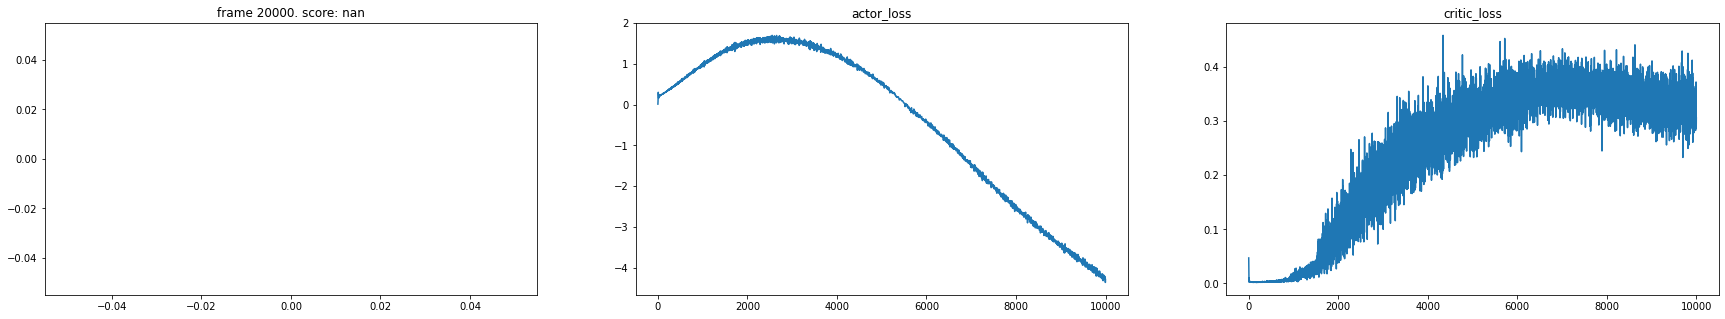

Streaming output truncated to the last 5000 lines.
reward of step 21520 is: 1.0698609933896517
reward of step 21521 is: 1.0392960870889965
reward of step 21522 is: 1.1090497431898998
reward of step 21523 is: 1.1052526472955377
reward of step 21524 is: 1.06653651819679
reward of step 21525 is: 1.075616862633809
reward of step 21526 is: 1.087968776940835
reward of step 21527 is: 1.1002173670578828
reward of step 21528 is: 1.0599142814021492
reward of step 21529 is: 1.0151300321561725
reward of step 21530 is: 1.0923512993100681
reward of step 21531 is: 1.124106678371477
reward of step 21532 is: 1.0477932954351852
reward of step 21533 is: 1.0519409206047305
reward of step 21534 is: 1.1849101610533164
reward of step 21535 is: 1.0938612861857153
reward of step 21536 is: 1.127094296938588
reward of step 21537 is: 1.0865666131555838
reward of step 21538 is: 1.0893811864727012
reward of step 21539 is: 1.112596447810527
reward of step 21540 is: 1.059037185234566
reward of step 21541 is: 1.099931

KeyboardInterrupt: ignored

In [ ]:
agent.train(num_frames)

# Test

In [ ]:
A = np.array([ -57.53854223, -44.63363074,0.        ])
B = np.array([-407.76417867,-564.62837335,0.        ])

print("Expand dims")
A = np.expand_dims(A, axis=0)
B = np.expand_dims(B, axis=0)
print(A-B)
np.sqrt(np.sum((A - B)**2,axis=1))

In [ ]:
power_radar   = 1000
power_bs_comm = 100
power_bs_priv = np.ones((5,1))
sigma2 = -10**(-18)  
B = 10**6
H_radar_uav   = np.array([7.32715132e-12])
H_user_radar  = np.array([[8.58882632e-14, 1.90202363e-13, 7.27181848e-14, 1.50638726e-13, 9.32527962e-14],
                [8.58882632e-14, 1.90202363e-13, 7.27181848e-14, 1.50638726e-13, 9.32527962e-14],
                [8.58882632e-14, 1.90202363e-13, 7.27181848e-14, 1.50638726e-13, 9.32527962e-14],
                [8.58882632e-14, 1.90202363e-13, 7.27181848e-14, 1.50638726e-13, 9.32527962e-14],
                [8.58882632e-14, 1.90202363e-13, 7.27181848e-14, 1.50638726e-13, 9.32527962e-14]])
# print(H_radar_uav)
# print(np.sum(power_bs_priv))
numerator = (H_radar_uav**2)*power_radar
print(numerator)
denominator = (H_user_radar**2) * (power_bs_comm + np.sum(power_bs_priv)) + (B*(sigma2))
print(denominator)
SINR = numerator/denominator
print(SINR)

In [ ]:
BS_x = 0
BS_y = 0
theta  = 0
UAV_trajectory = []
for i in range(1000):
    theta  = theta + np.pi/360
    print(theta)
    r      = 500*np.sin(theta/2)
    UAV_vx = r*np.cos(theta)
    UAV_vy = r*np.sin(theta)
    UAV_vh = 0
    UAV_trajectory.append([UAV_vx, UAV_vy, UAV_vh])
    fig, ax = plt.subplots()
    circle1 = plt.Circle((BS_x, BS_y), 1, color='r', fill=True)
    circle2 = plt.Circle((BS_x, BS_y), 100, color='g', fill=False)
    circle3 = plt.Circle((BS_x, BS_y), 1000, color='b', fill=False)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    ax.add_patch(circle3)
    gu = np.array(UAV_trajectory).transpose()[0:2].transpose()
    plt.scatter(gu[:,0], gu[:,1])
    plt.show()    

In [ ]:
import numpy as np

V = np.array([1,2,3,4,5])

# Private user exclude sum of user at this point
# Clone P_BS_U vector into P_BS_U matrix 
clonedM = np.ones((len(V),1))*V
print(f"clonedM: {clonedM}")
# Remove diagonal
diagonalExcludedM = clonedM -np.diag(np.diag(clonedM))
print(f"diagonalExcludedM: {diagonalExcludedM}")
# Sum over self-excluded matrix
rowWise_SumM = np.matrix(diagonalExcludedM).sum(axis=1)
print(f"rowWise_SumM: {rowWise_SumM}")

print(np.multiply(h.transpose(),rowWise_SumM))